Task 1:



In [176]:
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [177]:
"""
VISUALIZATION CODE
"""

def plot_discriminating_function(f, range=None):
    # Create a meshgrid
    if range is None:
        range = [[0,1],[0,1]]
    x = np.linspace(*range[0], 400)
    y = np.linspace(*range[1], 400)
    X, Y = np.meshgrid(x, y)

    Z = f(X, Y)
    plt.contourf(X, Y, Z, levels=[-10000, 0], colors=[(0.8, 0.2, 0.2, 0.36)])  # red fill for 5
    plt.contourf(X, Y, Z, levels=[0, 10000], colors=[(0.3, 0.3, 0.6, 0.36)])  # blue fill for 1

def plot_points(x, y):
    colors = ['blue' if value == 1 else 'red' for value in y]
    plt.scatter(x[:, 0], x[:, 1], color=colors, marker='x', s = 1)

In [178]:
"""
PREPROCESSING HELPER FUNCTION

formats image files and converts into numpy arrays of the same shape, then saves to specified location

Returns 0 upon success, otherwise returns 1 (unsuccessful may be due to undesirable properties such as
large aspect ratio)
"""

def process_file(file_path, processed_file_path, target_size = 256, aspect_ratio_thres = 1.3):
    with Image.open(file_path) as image:
        # crop out the longer dimension so it's square
        width, height = image.size
        new_size = min(width, height)
        if new_size * aspect_ratio_thres < max(width, height):
            # print(f'skipped due to aspect ratio too high')
            return 1
        left = (width - new_size) / 2
        top = (height - new_size) / 2
        right = (width + new_size) / 2
        bottom = (height + new_size) / 2
        image = image.crop((left, top, right, bottom))
        
        # resize
        image = image.resize((target_size, target_size))

        # convert the image to RGB
        image = image.convert('L')
        
        # convert to numpy array
        img_array = np.array(image)

        # print(f'processed array shape: {img_array.shape}')
        if img_array.shape != (target_size, target_size):
            print(f'error! wrong shape {img_array.shape}')
        
        # save to file
        np.save(processed_file_path, img_array)
        return 0

In [179]:
def feature_variation1(data):
    variance = np.var(data, axis=0)
    return np.sum(variance)

def feature_variation2(data):
    variance = np.var(data, axis=1)
    return np.sum(variance)

def feature_luminosity_variation1(data):
    lum = np.mean(data, axis=0)
    variance = np.var(lum, axis=0)
    return np.sum(variance)

def feature_luminosity_variation2(data):
    lum = np.mean(data, axis=1)
    variance = np.var(lum, axis=0)
    return np.sum(variance)


def get_conv_function(filter):
    return lambda row : np.convolve(row, filter, 'same')

def thresholding(data, category):

    randint = int(np.random.random() * 100)

    if randint == 0:
        print(f'image {category}')
        plt.imshow(data, interpolation='nearest')
        plt.show()

    filter = [-1,-0.5,0,0.5,1]
    result = np.apply_along_axis(get_conv_function(filter), 0, data)
    threshold = 30
    result = np.where(result < threshold, 0, result)

    if randint == 0:
        plt.imshow(result, interpolation='nearest')
        plt.show()
        time.sleep(1)

    return np.sum(result)



In [180]:
"""
FEATURE EXTRACTION HELPER FUNCTION

One of the feature extraction methods

Extracts exactly 5 features for every data point and returns them as 1D numpy array
"""

def extract_5_features(data, category):
    features = np.ones((5,))
    features[0] = thresholding(data, category)
    features[1] = feature_variation2(data)
    features[2] = feature_luminosity_variation1(data)
    features[3] = feature_luminosity_variation2(data)
    return features

In [181]:
"""
MAIN PIPELINE 1

preprocesses data by reading from directory and saves processed data into another directory with same structure.
"""

def preprocess(raw_data_dir, processed_data_dir):
    # Create the processed_data directory if it doesn't exist
    if not os.path.exists(processed_data_dir):
        os.makedirs(processed_data_dir)

    # List all subfolders in raw_data
    for subdir in os.listdir(raw_data_dir):
        print(f'reading directory {subdir}')
        raw_subdir_path = os.path.join(raw_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(raw_subdir_path):
            continue
        processed_subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Create the subfolder in processed_data if it doesn't exist
        if not os.path.exists(processed_subdir_path):
            os.makedirs(processed_subdir_path)
        
        count = 0
        processed_count = 0
        total = len(os.listdir(raw_subdir_path))
        # Process each file in the subdirectory
        for filename in os.listdir(raw_subdir_path):
            file_path = os.path.join(raw_subdir_path, filename)
            processed_file_path = os.path.join(processed_subdir_path, filename)
            
            # Process the file
            return_code = process_file(file_path, processed_file_path)
            count += 1
            if return_code == 0:
                processed_count += 1
            if count % 100 == 0 or count == total:
                print(f'traversed {count} / {total}, processed {processed_count}')
                
    print('finished preprocessing')

In [182]:
"""
MAIN PIPELINE 2

extracts features from processed data and returns them as two numpy arrays, X and Y
where X are the features for each data point and Y is their labels
"""

def import_features(processed_data_dir, features, features_extraction_function, folders=None, binary=False):
    total_items = 0
    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        total_items += len(os.listdir(subdir_path))
    print(f'found {total_items} items!')
        

    X = np.zeros((total_items, features))
    Y = np.zeros((total_items, 1))
    category_map = dict()

    category_counter = 0
    item_counter = 0

    if binary: category_counter = -1

    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        print(f'reading directory {subdir}')
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        
        # Process each file in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            data = np.load(file_path)
            features = features_extraction_function(data, category_counter)
            X[item_counter] = features
            Y[item_counter][0] = category_counter
            item_counter += 1

            if item_counter % 100 == 0:
                print(f'processed {item_counter}/{len(os.listdir(subdir_path))}')
        
        category_map[category_counter] = subdir
        category_map[subdir] = category_counter
        category_counter += 1

        if binary: category_counter += 1

    print('finished feature import')
    return X, Y, category_map

In [183]:
"""
MAIN PIPELINE LEARNING: LOGISTIC REGRESSION

all the functions for computing the logistic regression.
"""

def sigmoid(x):
    e = 1e-6
    return np.clip(1/(1 + np.exp(-x)), e, 1 - e)

def logistic_loss(x, y, w):
    h = sigmoid(x @ w)
    return (-1 / len(x)) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

def logistic_optimize(x, y, a, iters=10000):
    m, n = x.shape
    w = np.random.randn(n, 1)
    print_interval = int(iters/10)
    cost_history = np.zeros((int(iters/print_interval),))

    last_printed = -1

    for i in range(iters):
        if i % print_interval == 0:
            print(f'iteration {i} / {iters}')
            incorrect = np.sum(test(x, y, w))
            print(f'accuracy: {(len(x) - incorrect) / len(x)}')

        gradient = (1/m) * x.T @ (sigmoid(x @ w) - y)
        w -= a * gradient
        if i % print_interval == 0:
            last_printed += 1
            a *= 0.8
            cost_history[last_printed] = (logistic_loss(x, y, w))

    return np.reshape(w, (n,)), cost_history

def logistic_sto_optimize(x, y, a, epoch=100):
    m, n = x.shape
    w = np.random.randn(n, 1)
    x_reshaped = np.reshape(x, (m, n, 1))
    print_interval = int(epoch/10)
    cost_history = np.zeros((10,))

    last_printed = -1

    for e in range(epoch):
        if e % print_interval == 0:
            print(f'epoch {e} / {epoch}')
        for i in range(len(x_reshaped)):
            xi = x_reshaped[i, :]
            yi = y[i]
            #print(f'x shape: {xi.shape} y shape: {yi.shape} w shape: {w.shape}')
            gradient = (sigmoid(xi.T @ w) - yi) * xi
            w -= a * gradient
        if e % print_interval == 0:
            last_printed += 1
            a *= 0.8
            cost_history[last_printed] = (logistic_loss(x, y, w))

    return np.reshape(w, (n,)), cost_history

def test(x, y, w):
    results = np.sign(np.matmul(x, w))
    stacked = np.column_stack((y, results))
    comparison =  np.abs(0.5 * (stacked[:, 0] - stacked[:, 1]))
    return comparison

found 2526 items!
reading directory Art_Nouveau
processed 100/777
processed 200/777
processed 300/777
processed 400/777
processed 500/777
processed 600/777
processed 700/777
reading directory Realism
processed 800/1749
processed 900/1749
processed 1000/1749
processed 1100/1749
processed 1200/1749
processed 1300/1749
processed 1400/1749
processed 1500/1749
processed 1600/1749
processed 1700/1749
processed 1800/1749
processed 1900/1749
processed 2000/1749
processed 2100/1749
processed 2200/1749
processed 2300/1749
processed 2400/1749
processed 2500/1749
finished feature import
X shape: (2526, 5)
Y Shape: (2526, 1)
Category Map: {-1: 'Art_Nouveau', 'Art_Nouveau': -1, 1: 'Realism', 'Realism': 1}

Y sum: 972.0


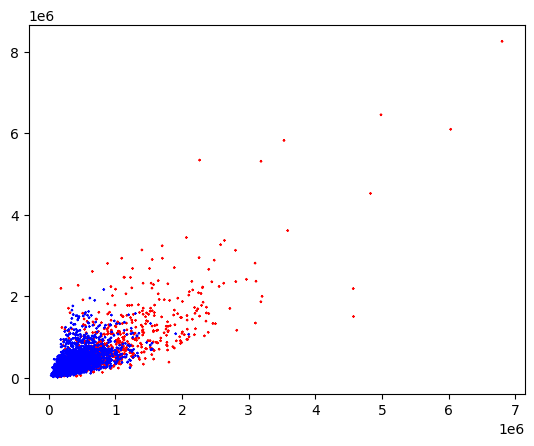

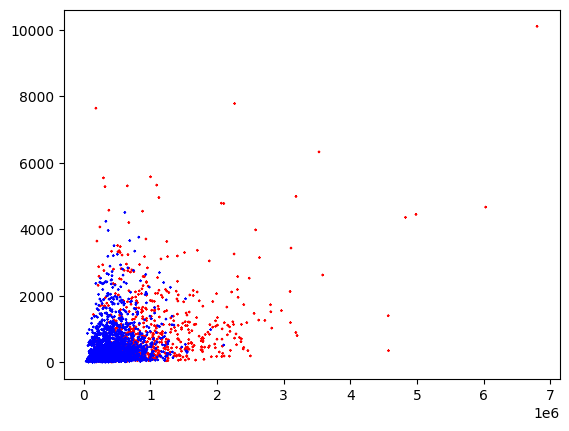

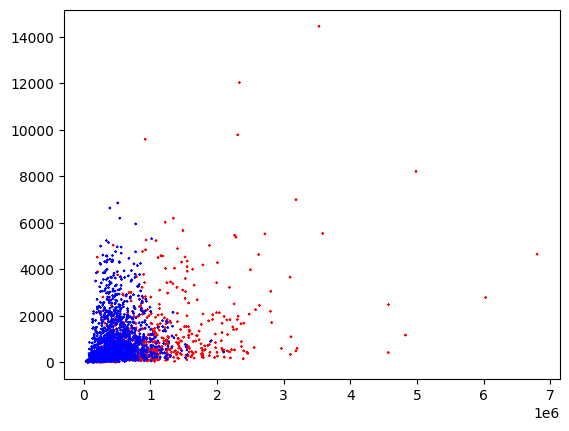

iteration 0 / 100000
accuracy: 0.30760095011876487


C:\Users\eggyr\AppData\Local\Temp\ipykernel_19196\504074271.py:9: RuntimeWarning: overflow encountered in exp
  return np.clip(1/(1 + np.exp(-x)), e, 1 - e)
C:\Users\eggyr\AppData\Local\Temp\ipykernel_19196\504074271.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_history[last_printed] = (logistic_loss(x, y, w))


iteration 10000 / 100000
accuracy: 0.30760095011876487
iteration 20000 / 100000
accuracy: 0.30760095011876487
iteration 30000 / 100000
accuracy: 0.32145684877276326
iteration 40000 / 100000
accuracy: 0.32145684877276326
iteration 50000 / 100000
accuracy: 0.3475851148060174
iteration 60000 / 100000
accuracy: 0.3475851148060174
iteration 70000 / 100000
accuracy: 0.3479809976247031
iteration 80000 / 100000
accuracy: 0.3475851148060174


KeyboardInterrupt: 

In [184]:
"""
RUNNER
"""

# directory containing original images
raw_data_dir = '../../Data/Art'

# directory to save processed numpy arrays
processed_data_dir = '../../Data/Art_Processed'

# specifies which categories to read from. Leave as None to read from all
folders = ['Art_Nouveau','Realism']

#preprocess(raw_data_dir, processed_data_dir)

# category map represents the mapping for storing categories as an integer rather than having to use their original string
X, Y, category_map = import_features(processed_data_dir, 5, extract_5_features, folders, True)
print(f'X shape: {X.shape}\nY Shape: {Y.shape}\nCategory Map: {category_map}\n')
print(f'Y sum: {np.sum(Y)}')

plot_points(X[:, [0, 1]], Y)
plt.show()

plot_points(X[:, [0, 2]], Y)
plt.show()

plot_points(X[:, [0, 3]], Y)
plt.show()

weights, costs = logistic_optimize(X, Y, 0.1, 100000)
test(X, Y, weights)


